In [6]:
import numpy as np
import pandas as pd
from ta import momentum
import ccxt
from pymoo.algorithms.moo.age import AGEMOEA
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

In [7]:
fee = 0.01

def fetch_data(timeframe):
    exchange = ccxt.kraken()
    start_timestamp = 1451606400000  # timestamp for 1 Jan 2016
    end_timestamp = 1651392000000  # timestamp for 1 May 2023
    interval_seconds = exchange.parse_timeframe(timeframe) * 60  # convert timeframe to seconds
    limit = int((end_timestamp - start_timestamp) / interval_seconds) + 1
    ohlcv = exchange.fetch_ohlcv('BTC/AUD', timeframe=timeframe, since=start_timestamp, limit=limit)
    return ohlcv

ohlcv = fetch_data('1d')
df = pd.DataFrame(ohlcv)
df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
df['time'] = pd.to_datetime(df['time'], unit='ms')
df['returns'] = df['close'].pct_change()

def rsi_strategy(rsi_period, rsi_sell, rsi_buy, df):
    rsi_sell = int(rsi_sell)
    rsi_period = int(rsi_period)
    rsi_buy = int(rsi_buy)
    df['RSI'] = momentum.rsi(df['close'],rsi_period)
    df['rsi_signal'] = 1*(df['RSI'] > rsi_buy)- 1*(df['RSI'] < rsi_sell)
    start = rsi_period
    RSI_return = np.array(df['returns'][start+1:])*np.array(df['rsi_signal'][start+1:]) - fee*abs(np.array(df['rsi_signal'][start+1:]) - np.array(df['rsi_signal'][start:-1]))
    RSI = np.prod(1+RSI_return)**(252/len(RSI_return)) - 1
    RSI_risk = np.std(RSI_return)*252*0.5
    return RSI, 1/RSI_risk
net_profit, risk = rsi_strategy(25, 30, 70, df)


In [27]:
class RSIStrategyProblem(Problem):

    def __init__(self, df):
        super().__init__(n_var=3,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([5, 20, 60]),
                         xu=np.array([30, 40, 80]))

        self.df = df

    def _evaluate(self, X, out, *args, **kwargs):
        f1 = []
        f2 = []

        for i in range(X.shape[0]):
            rsi_period, rsi_sell, rsi_buy = X[i, :]
            net_profit, std_dev = rsi_strategy(rsi_period, rsi_sell, rsi_buy, self.df)
            f1.append(net_profit)
            f2.append(std_dev)

        k = 0
        while k < len(f2):
            if f2[k] < 0:
                f1[k].remove()
                f2[k].remove()
            k += 1


        out["F"] = np.column_stack([f1, f2])

C:\Users\cwalt\AppData\Local\Temp\ipykernel_29532\2508952609.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  return RSI, 1/RSI_risk


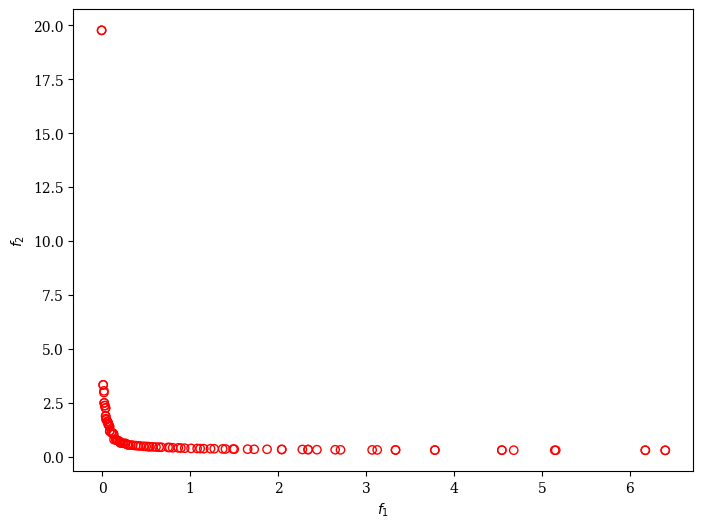

In [36]:
problem = RSIStrategyProblem(df)

algorithm = AGEMOEA(pop_size=100)


res = minimize(problem,
               algorithm,
               ('n_gen', 1000),
               seed=1,
               verbose=False)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

In [48]:
values = res.F
sorted_indices = np.argsort(values[:,0])
sorted_values = values[sorted_indices]
sorted_values

array([[-4.89894635e-03,  1.97716778e+01],
       [-4.89894635e-03,  1.97716778e+01],
       [ 1.29300556e-02,  3.35026377e+00],
       [ 1.29300556e-02,  3.35026377e+00],
       [ 2.16900509e-02,  3.07022091e+00],
       [ 2.17130722e-02,  2.98917750e+00],
       [ 2.44124199e-02,  2.51229237e+00],
       [ 2.44124199e-02,  2.51229237e+00],
       [ 3.17602468e-02,  2.38667326e+00],
       [ 3.17602468e-02,  2.38667326e+00],
       [ 4.00995172e-02,  2.27619700e+00],
       [ 4.00995172e-02,  2.27619700e+00],
       [ 4.11084052e-02,  1.90860627e+00],
       [ 4.14114985e-02,  1.90175939e+00],
       [ 4.55980979e-02,  1.78527795e+00],
       [ 4.64676309e-02,  1.73080610e+00],
       [ 6.07936262e-02,  1.66055318e+00],
       [ 6.67325959e-02,  1.62387049e+00],
       [ 6.83012449e-02,  1.53366690e+00],
       [ 7.45074003e-02,  1.51254752e+00],
       [ 7.46101086e-02,  1.50175118e+00],
       [ 8.50406752e-02,  1.41616833e+00],
       [ 8.50406752e-02,  1.41616833e+00],
       [ 8.

In [50]:
best_ratio = 0.0
ratio_vals = []
for i in sorted_values:
    if i[0]/i[1] > best_ratio:
        best_ratio = i[0]/i[1]
        ratio_vals = [i[0],i[1]]

print(best_ratio, ratio_vals)

0.9886122661796388 [0.49593627807500146, 0.5016489224754226]
